In [1]:
import tarfile
import urllib.request
import tempfile
import anndata as ad
import scanpy as sc

import pandas as pd
import numpy as np
import seaborn as sb
from scipy import io, sparse
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import pickle
import copy

import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
%load_ext rpy2.ipython

In [57]:
%%R
old_paths <- .libPaths()[-1]
new_paths <- c("~/R/nips", old_paths)
.libPaths(new_paths)

suppressMessages(library("dplyr"))
suppressMessages(library("Seurat"))
suppressMessages(library("anndata"))
suppressMessages(library("SingleCellExperiment"))
suppressMessages(library("scran"))
suppressMessages(library("Matrix"))

In [3]:
## VIASH START
par = {
    "id": "totalVI_x_malt_k",
    "input": "https://github.com/YosefLab/totalVI_reproducibility/raw/master/data/malt_10k_protein_v3.h5ad",
    "organism": "human",
    "output_rna": "output_rna.h5ad",
    "output_mod2": "output_mod2.h5ad"
}
## VIASH END

###############################################################################
###                     DOWNLOAD AND READ DATA.                             ###
###############################################################################
print("Downloading file from", par['input'])
h5ad_temp = tempfile.NamedTemporaryFile()
url = par['input']
urllib.request.urlretrieve(url, h5ad_temp.name)

print("Reading h5ad file")
adata = sc.read_h5ad(h5ad_temp.name)
h5ad_temp.close()

###############################################################################
###                     CREATE H5AD FOR BOTH MODALITIES                     ###
###############################################################################
uns = { "dataset_id" : par["id"], "organism" : par["organism"] }

print("Extracting RNA counts")
adata_RNA = ad.AnnData(
    X=adata.X,
    obs=adata.obs.loc[:,['n_genes', 'percent_mito', 'n_counts']],
    var=adata.var,
    uns=uns
)

adata_RNA.var['feature_types'] = "GEX"

print("Extracting ADT counts")
adata_ADT = ad.AnnData(
    X=adata.obsm['protein_expression'],
    var=pd.DataFrame(index=list(adata.uns['protein_names'])),
    uns=uns
)

adata_ADT.obs.index = adata.obs.index
adata_ADT.var['feature_types'] = "ADT"

###############################################################################
###                             SAVE OUTPUT                                 ###
###############################################################################

# Convert to sparse matrices
adata_RNA.X = sparse.csr_matrix(adata_RNA.X)
adata_ADT.X = sparse.csr_matrix(adata_ADT.X)

print("Saving output")
adata_RNA.write_h5ad(par['output_rna'], compression = "gzip")
adata_ADT.write_h5ad(par['output_mod2'], compression = "gzip")

Reading h5ad file
Extracting RNA counts
Extracting ADT counts


/home/alina/Downloads/ENTER/envs/nips/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


Saving output


/home/alina/Downloads/ENTER/envs/nips/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


# I. GEX modality

## 1. QC metrics

In [4]:
# pct_counts_mt
mito_genes = adata_RNA.var_names.str.startswith('MT-')
adata_RNA.obs['pct_counts_mt'] = (np.sum(adata_RNA[:, mito_genes].X, axis=1).A1 / np.sum(adata_RNA.X, axis=1).A1)*100
adata_RNA.obs['pct_counts_mt'].max()

14.992211

In [5]:
# UMI counts per cell
# rows: n of cells = 7361; columns: n of genes = 36601
# asarray convert matrix (7361, 1) to array (7361,)
adata_RNA.obs['n_counts'] = np.asarray(np.sum(adata_RNA.X, axis = 1)).reshape(-1)
adata_RNA.obs['n_counts'].min()

590.0

In [6]:
# n of genes per cell
adata_RNA.obs['n_genes'] = np.asarray((adata_RNA.X > 0).sum(axis=1)).reshape(-1)
adata_RNA.obs['n_genes'].min()

337

In [7]:
adata_RNA

AnnData object with n_obs × n_vars = 6838 × 16659
    obs: 'n_genes', 'percent_mito', 'n_counts', 'pct_counts_mt'
    var: 'n_cells', 'highly_variable', 'feature_types'
    uns: 'dataset_id', 'organism'

In [12]:
# Copy AnnData object

adata_RNA_filtered = copy.copy(adata_RNA)
adata_RNA_filtered.shape

(6838, 16659)

In [13]:
# Filter cells according to identified QC thresholds:

print('Total number of cells: {:d}'.format(adata_RNA_filtered.n_obs))

sc.pp.filter_cells(adata_RNA_filtered, min_counts = 1500)

print('Number of cells after min count filter: {:d}'.format(adata_RNA_filtered.n_obs))

sc.pp.filter_cells(adata_RNA_filtered, max_counts = 40000)
print('Number of cells after max count filter: {:d}'.format(adata_RNA_filtered.n_obs))

adata_RNA_filtered = adata_RNA_filtered[adata_RNA_filtered.obs['pct_counts_mt'] < 20]
print('Number of cells after MT filter: {:d}'.format(adata_RNA_filtered.n_obs))

sc.pp.filter_ce     l999ls(adata_RNA_filtered, min_genes = 700)
print('Number of cells after gene filter: {:d}'.format(adata_RNA_filtered.n_obs))

Total number of cells: 6838
Number of cells after min count filter: 6781
Number of cells after max count filter: 6781
Number of cells after MT filter: 6781


Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 6765


In [14]:
# Filter genes

print('Total number of genes: {:d}'.format(adata_RNA.n_vars))

Total number of genes: 16659


In [15]:
# Min 20 cells: filters out 0 count genes

sc.pp.filter_genes(adata_RNA_filtered, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_RNA_filtered.n_vars))

Number of genes after cell filter: 12629


In [16]:
adata_RNA.write('./adata_RNA.h5ad')
adata_RNA_filtered.write('./adata_RNA_filtered.h5ad')

## 2. Normalization (size factors)

In [17]:
# Perform a clustering for scran normalization in clusters

adata_pp = adata_RNA_filtered.copy()

sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

In [18]:
# Preprocess variables for scran normalization

input_groups = adata_pp.obs['groups']
data_mat = adata_RNA_filtered.X.T
io.mmwrite("data_mat.mtx", data_mat, comment='', field=None, precision=None, symmetry=None)

In [19]:
%%R -i input_groups -o size_factors

data_mat <- readMM("./data_mat.mtx")
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

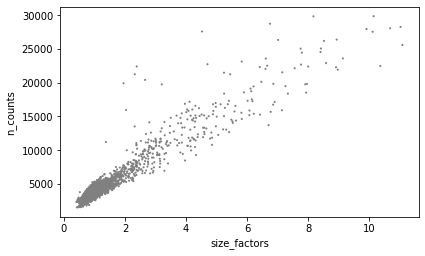

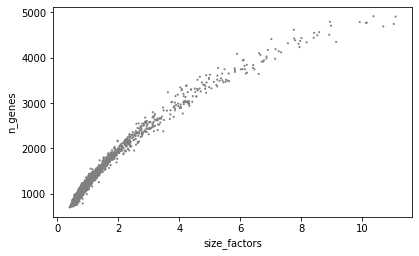

/home/alina/Downloads/ENTER/envs/nips/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


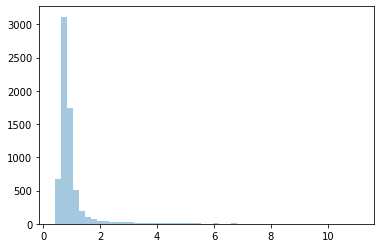

In [20]:
# Visualize the estimated size factors
adata_RNA_filtered.obs['size_factors'] = size_factors

sc.pl.scatter(adata_RNA_filtered, 'size_factors', 'n_counts')
sc.pl.scatter(adata_RNA_filtered, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [21]:
# Keep the count data in a counts layer
adata_RNA_filtered.layers["counts"] = adata_RNA_filtered.X.copy()

In [22]:
# Normalize & Log-transform 
adata_RNA_filtered.X /= adata_RNA_filtered.obs['size_factors'].values[:,None]
adata_RNA_filtered.layers["log_norm"] = sc.pp.log1p(adata_RNA_filtered.X)

In [23]:
adata_RNA_filtered.write("adata_RNA_filtered")

# II. ADT modality

## 1. QC metrics

In [25]:
# Delete last 10 characters in protein names "_TotalSeqB"
# CD3_TotalSeqB -> CD3
adata_ADT.var.index = [x[:-10] for x in adata_ADT.var.index.tolist()]

In [28]:
adata_ADT

AnnData object with n_obs × n_vars = 6838 × 14
    var: 'feature_types'
    uns: 'dataset_id', 'organism'

In [29]:
# ADT counts per cell

adata_ADT.obs['total_counts'] = np.asarray(np.sum(adata_ADT.X, axis = 1)).reshape(-1)
adata_ADT.obs['total_counts'].min()

418.0

In [31]:
# N of proteins per cell

adata_ADT.obs['n_genes'] = np.asarray((adata_ADT.X > 0).sum(axis=1)).reshape(-1)
adata_ADT.obs['n_genes'].min()

12

In [32]:
# ADT count of the 6 isotype controls summed up in each cell: [1; 100]

# no isotype controls here

14

In [50]:
# Copy AnnData object

adata_ADT_filtered = copy.copy(adata_ADT)
adata_ADT.shape

(6838, 14)

In [51]:
# Filter cells according to identified QC thresholds:

print('Total number of cells: {:d}'.format(adata_ADT_filtered.n_obs))

sc.pp.filter_cells(adata_ADT_filtered, min_counts = 1100)

print('Number of cells after min count filter: {:d}'.format(adata_ADT_filtered.n_obs))

sc.pp.filter_cells(adata_ADT_filtered, max_counts = 24000)
print('Number of cells after max count filter: {:d}'.format(adata_ADT_filtered.n_obs))

sc.pp.filter_cells(adata_ADT_filtered, min_genes = 8)  # 60% of n_genes
print('Number of cells after protein number filter: {:d}'.format(adata_ADT_filtered.n_obs))

Total number of cells: 6838
Number of cells after min count filter: 5866
Number of cells after max count filter: 5866
Number of cells after protein number filter: 5866


In [52]:
# Filter genes

print('Total number of genes: {:d}'.format(adata_ADT.n_vars))

Total number of genes: 14


In [53]:
# Min 20 cells: filters out 0 count genes

sc.pp.filter_genes(adata_ADT_filtered, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_ADT_filtered.n_vars))

Number of genes after cell filter: 14


In [54]:
adata_ADT.write('./adata_ADT.h5ad')

## 2. Normalization (CLR)

In [55]:
# Keep the count data in a counts layer

adata_ADT_filtered.layers["counts"] = adata_ADT_filtered.X.copy()

In [62]:
def CLR_transform(sparse):
    '''
    implements the CLR transform used in CITEseq (need to confirm in Seurat's code)
    https://doi.org/10.1038/nmeth.4380
    source: https://github.com/theislab/scanpy/pull/1117
    '''
    df = pd.DataFrame.sparse.from_spmatrix(sparse)
    logn1 = np.log(df + 1)
    T_clr = logn1.sub(logn1.mean(axis=1), axis=0)
    return T_clr

In [64]:
# Perform centre log ratio (CLR) transformation
# Store transformed data in adata.X

adata_ADT_filtered.X = CLR_transform(adata_ADT_filtered.X)

In [70]:
adata_RNA_filtered.write("adata_RNA_filtered.h5ad")